In [25]:
"""
grid_defense_ising.py

Self-contained demo:
- Builds a sample power grid (small 5-bus network).
- Models defend–attack–operate planning.
- Uses a max-flow-based disruption oracle (proxy for DC-OPF).
- Fits a quadratic surrogate for disruption (QUBO-style).
- Runs an adversarial parallel-tempering (APT) annealer to pick defenses.
- Compares with a greedy baseline and (if feasible) brute-force.

No external dependencies beyond standard library.
"""

from __future__ import annotations
import random
import itertools
import math
from collections import defaultdict, deque
from dataclasses import dataclass
from typing import Dict, List, Tuple, Iterable

# -----------------------------
# Power grid & max-flow oracle
# -----------------------------

@dataclass
class Edge:
    u: int
    v: int
    capacity: float
    name: str

class PowerGrid:
    """
    Simple undirected capacity network with (now) support for multiple generator buses.
    Disruption (shed) is approximated by MAX-FLOW from a super-source connected to all
    generator buses to a super-sink aggregating all load buses.

    Attributes (backward compatible):
      gen_bus : int                (primary / first generator bus)
      gen_cap : float              (capacity of primary generator bus)
      generators : Dict[int,float] (all generator buses and their individual capacities)
    """
    def __init__(self, n_buses: int, gen_bus: int, generator_cap: float):
        self.n = n_buses
        self.gen_bus = gen_bus              # primary
        self.gen_cap = generator_cap        # primary capacity (kept for compatibility)
        self.generators: Dict[int, float] = {gen_bus: generator_cap}
        self.loads: Dict[int, float] = {}   # bus -> demand
        self.edges: List[Edge] = []
        self.edge_index: Dict[str, int] = {}

    # --- Generation / load management ---
    def add_generator(self, bus: int, capacity: float, overwrite: bool = False):
        """Add an additional generator bus (or update if overwrite=True).
        Does not alter the original gen_bus/gen_cap unless adding the first time.
        """
        if bus == self.gen_bus and not overwrite:
            # augment existing primary capacity (interpreted as separate unit)
            self.generators[bus] = self.generators.get(bus, 0.0) + capacity
        else:
            # add / set
            if overwrite or bus not in self.generators:
                self.generators[bus] = capacity
            else:
                self.generators[bus] += capacity

    def total_generation_capacity(self) -> float:
        return sum(self.generators.values())

    def is_generator(self, bus: int) -> bool:
        return bus in self.generators

    def add_load(self, bus: int, demand: float):
        self.loads[bus] = self.loads.get(bus, 0.0) + demand

    def add_line(self, u: int, v: int, capacity: float, name: str):
        idx = len(self.edges)
        self.edges.append(Edge(u, v, capacity, name))
        self.edge_index[name] = idx

    # --- Topology helpers ---
    def line_count(self) -> int:
        return len(self.edges)

    def availability_from_decisions(self, defend: List[int], attack: List[int]) -> List[int]:
        # z_i = 1 - a_i * (1 - d_i)
        m = self.line_count()
        z = [1]*m
        for i in range(m):
            ai = attack[i]
            di = defend[i]
            z[i] = 1 - ai * (1 - di)
        return z

    # --- Flow oracle construction ---
    def _build_directed_capacity_graph(self, z: List[int]):
        # Build directed graph for max-flow:
        # - For each undirected line (u-v, cap*c_avail), add (u->v) and (v->u) arcs.
        # - Add super-sink T connected from each load bus with arc capacity = demand.
        # - Add super-source S connected to EACH generator bus with its capacity.
        n = self.n
        S = 0
        T = n + 1
        N = T + 1
        adj = [[] for _ in range(N)]
        cap = defaultdict(float)

        def add_arc(a, b, c):
            if c <= 0: return
            adj[a].append(b)
            adj[b].append(a)
            cap[(a,b)] += c
            cap[(b,a)] += 0.0  # ensure reverse arc exists

        # generator super-source arcs
        for g_bus, g_cap in self.generators.items():
            add_arc(S, g_bus, g_cap)

        # undirected lines -> two directed arcs
        for i, e in enumerate(self.edges):
            if z[i] == 0:
                continue
            c = e.capacity
            add_arc(e.u, e.v, c)
            add_arc(e.v, e.u, c)

        # load arcs to super-sink
        total_demand = 0.0
        for bus, d in self.loads.items():
            total_demand += d
            add_arc(bus, T, d)

        return S, T, adj, cap, total_demand

    def _edmonds_karp(self, S, T, adj, cap):
        flow = 0.0
        parent = {}
        while True:
            parent = {S: None}
            q = deque([S])
            while q and T not in parent:
                u = q.popleft()
                for v in adj[u]:
                    if v not in parent and cap[(u,v)] > 1e-12:
                        parent[v] = u
                        q.append(v)
                        if v == T:
                            break
            if T not in parent:
                break
            # augment
            aug = float('inf')
            v = T
            while v != S:
                u = parent[v]
                aug = min(aug, cap[(u,v)])
                v = u
            v = T
            while v != S:
                u = parent[v]
                cap[(u,v)] -= aug
                cap[(v,u)] += aug
                v = u
            flow += aug
        return flow

    def evaluate_shed(self, defend: List[int], attack: List[int]) -> float:
        """
        Returns total shed = max(0, total_demand - maxflow).
        Multiple generators supported: super-source distributes to all generator buses with their capacities.
        """
        z = self.availability_from_decisions(defend, attack)
        S,T,adj,cap,total_demand = self._build_directed_capacity_graph(z)
        maxflow = self._edmonds_karp(S,T,adj,cap)
        shed = max(0.0, total_demand - maxflow)
        return shed

# -----------------------------
# Surrogate fitting (quadratic)
# -----------------------------

def fit_quadratic_surrogate(grid: PowerGrid, Ka: int, max_enum: int = 2):
    """
    Fit g_hat(z) = a0 + sum a_i b_i + sum_{i<j} a_ij b_i b_j
    where b_i = (1 - z_i) = a_i * (1 - d_i).
    During fitting, we enumerate attack sets only (defense absent), i.e., d=0.
    Then b_i reduces to attack indicator for line i.

    Returns (a0, a1, a2) where a1 is list length m, a2 is m x m symmetric matrix.
    """
    m = grid.line_count()
    # Build design & response
    attacks = [tuple()]  # empty set
    for k in range(1, max_enum+1):
        for comb in itertools.combinations(range(m), k):
            attacks.append(comb)

    X = []
    y = []
    # We'll set defense all zeros for fitting, then availability z = 1 - a
    for A in attacks:
        a = [0]*m
        for i in A:
            a[i] = 1
        d = [0]*m
        shed = grid.evaluate_shed(d, a)
        # features: 1, a_i, a_i a_j
        row = [1.0] + a[:]
        pair_terms = []
        for i in range(m):
            for j in range(i+1, m):
                pair_terms.append(a[i]*a[j])
        row += pair_terms
        X.append(row)
        y.append(shed)

    # Solve least squares X beta = y
    import numpy as np
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    a0 = float(beta[0])
    a1 = beta[1:1+m]
    a2 = np.zeros((m,m))
    idx = 1+m
    for i in range(m):
        for j in range(i+1, m):
            a2[i,j] = beta[idx]
            a2[j,i] = beta[idx]
            idx += 1
    # RMSE
    rmse = float(np.sqrt(np.mean((X.dot(beta) - y)**2)))
    return a0, a1, a2, rmse

# -----------------------------
# QUBO construction (approx.)
# -----------------------------

def build_qubo(a0, a1, a2, m, Kd, Ka, mu_d=1000.0, mu_a=1000.0):
    """
    Variables x = [d(0..m-1), a(0..m-1)] in {0,1}
    We approximate g_hat via b_i = a_i*(1-d_i) and keep only linear and ai*aj terms.
    Then add budget penalties:
      + mu_d (sum d - Kd)^2
      - mu_a (sum a - Ka)^2   (attacker encouraged to use full budget)
    Returns Q (2m x 2m) symmetric.
    """
    import numpy as np
    n = 2*m
    Q = np.zeros((n,n), dtype=float)

    # Linear from a1: a1_i * (a_i - a_i d_i)
    for i in range(m):
        idx_d = i
        idx_a = m + i
        Q[idx_a, idx_a] += a1[i]
        Q[idx_d, idx_a] += -0.5 * a1[i]
        Q[idx_a, idx_d] += -0.5 * a1[i]

    # Pairwise: approximate b_i b_j ~ a_i a_j
    for i in range(m):
        for j in range(i+1, m):
            idx_ai = m + i
            idx_aj = m + j
            Q[idx_ai, idx_aj] += a2[i,j]
            Q[idx_aj, idx_ai] += a2[i,j]

    # Defender budget penalty +mu_d (sum d - Kd)^2
    # (sum d)^2 = sum d_i + 2 sum_{i<j} d_i d_j  (since d_i^2 = d_i)
    for i in range(m):
        Q[i,i] += mu_d * (1 - 2*Kd)
    for i in range(m):
        for j in range(i+1, m):
            Q[i,j] += 2*mu_d
            Q[j,i] += 2*mu_d

    # Attacker budget encouragement -mu_a (sum a - Ka)^2
    for i in range(m):
        Q[m+i, m+i] += -mu_a * (1 - 2*Ka)
    for i in range(m):
        for j in range(i+1, m):
            Q[m+i, m+j] += -2*mu_a
            Q[m+j, m+i] += -2*mu_a

    return Q

# -----------------------------
# Evaluators & baselines
# -----------------------------

def enumerate_best_attack(grid: PowerGrid, d: List[int], Ka: int) -> Tuple[List[int], float]:
    m = grid.line_count()
    best_shed = -1.0
    best_a = [0]*m
    for A in itertools.combinations(range(m), Ka):
        a = [0]*m
        for i in A:
            a[i] = 1
        shed = grid.evaluate_shed(d, a)
        if shed > best_shed:
            best_shed = shed
            best_a = a
    return best_a, best_shed

def greedy_defense(grid: PowerGrid, Kd: int, Ka: int) -> Tuple[List[int], List[int], float]:
    m = grid.line_count()
    d = [0]*m
    for _ in range(Kd):
        best_gain = -1e18
        best_i = None
        # try defending i not already defended
        for i in range(m):
            if d[i] == 1: continue
            d_try = d[:]
            d_try[i] = 1
            a_star, worst = enumerate_best_attack(grid, d_try, Ka)
            gain = -worst
            if gain > best_gain:
                best_gain = gain
                best_i = i
        d[best_i] = 1
    a_star, worst = enumerate_best_attack(grid, d, Ka)
    return d, a_star, worst

def energy_qubo(Q, x):
    import numpy as np
    v = np.array(x, dtype=float).reshape(-1,1)
    return float(v.T @ Q @ v)

# -----------------------------
# Adversarial PT annealer
# -----------------------------

def apt_annealer(grid: PowerGrid, Q, Kd: int, Ka: int, iters: int = 1000, R: int = 12, Tmax: float = 5.0, Tmin: float = 0.01, seed: int = 0):
    random.seed(seed)
    import numpy as np
    m = grid.line_count()
    n = 2*m
    # Initialize replicas with feasible d (exact Kd) and random a (exact Ka)
    replicas = []
    for r in range(R):
        d = [0]*m
        for i in random.sample(range(m), Kd):
            d[i] = 1
        a = [0]*m
        for i in random.sample(range(m), Ka):
            a[i] = 1
        replicas.append(d + a)

    temps = [Tmax * (Tmin/Tmax)**(r/(R-1)) for r in range(R)]

    best_d = None
    best_a = None
    best_worst = float('inf')

    def project_budget(vec, start, length, K):
        idx1 = [i for i in range(length) if vec[start+i]==1]
        if len(idx1) > K:
            for i in random.sample(idx1, len(idx1)-K):
                vec[start+i] = 0
        elif len(idx1) < K:
            idx0 = [i for i in range(length) if vec[start+i]==0]
            for i in random.sample(idx0, K-len(idx1)):
                vec[start+i] = 1

    for it in range(iters):
        # Local updates with attacker ascent and defender descent
        for r in range(R):
            x = replicas[r][:]
            T = temps[r]

            # Attacker ascent: flip some a-bits (encourage higher surrogate energy)
            for _ in range(3):
                i = m + random.randrange(m)
                x[i] = 1 - x[i]
                project_budget(x, m, m, Ka)
                dE = energy_qubo(Q, x) - energy_qubo(Q, replicas[r])
                exp_term = min(700, dE / max(1e-12, T))
                if dE >= 0 or random.random() < math.exp(exp_term):
                    replicas[r] = x[:]
                else:
                    x = replicas[r][:]

            # Defender descent: flip some d-bits (seek lower surrogate energy)
            for _ in range(3):
                i = random.randrange(m)
                x[i] = 1 - x[i]
                project_budget(x, 0, m, Kd)
                dE = energy_qubo(Q, x) - energy_qubo(Q, replicas[r])
                exp_term = min(700, -dE / max(1e-12, T))
                if dE <= 0 or random.random() < math.exp(exp_term):
                    replicas[r] = x[:]
                else:
                    x = replicas[r][:]

        # Parallel tempering swaps between adjacent replicas
        for r in range(R-1):
            x1 = replicas[r]
            x2 = replicas[r+1]
            E1 = energy_qubo(Q, x1)
            E2 = energy_qubo(Q, x2)
            beta1 = 1.0 / max(1e-12, temps[r])
            beta2 = 1.0 / max(1e-12, temps[r+1])
            exp_term = min(700, (beta1 - beta2) * (E2 - E1))
            acc = min(1.0, math.exp(exp_term))
            if random.random() < acc:
                replicas[r], replicas[r+1] = x2, x1

        # Evaluate true worst-case on each replica's defense; keep the best
        for r in range(R):
            d = replicas[r][:m]
            a_star, worst = enumerate_best_attack(grid, d, Ka)
            if worst < best_worst:
                best_worst = worst
                best_d = d[:]
                best_a = a_star[:]

        if (it+1) % max(1, iters//10) == 0:
            print(f"[APT] iter {it+1}/{iters}: current best worst-case shed = {best_worst:.4f}")

    return best_d, best_a, best_worst

# -----------------------------
# Sample grid builder
# -----------------------------

def build_sample_grid() -> Tuple[PowerGrid, List[str]]:
    """
    5-bus toy network.
    Bus 1: (primary) generator (can add more with add_generator)
    Buses 2..5: loads
    Lines approximate a meshed small network.
    """
    g = PowerGrid(n_buses=5, gen_bus=1, generator_cap=180.0)
    # Example: add a second small generator at bus 3 (commented out)
    # g.add_generator(3, 50.0)
    # demands
    g.add_load(2, 40.0)
    g.add_load(3, 50.0)
    g.add_load(4, 45.0)
    g.add_load(5, 35.0)
    # lines (u, v, capacity, name)
    lines = [
        (1,2,70.0,"L12"),
        (1,3,60.0,"L13"),
        (2,3,40.0,"L23"),
        (2,4,60.0,"L24"),
        (3,5,60.0,"L35"),
        (4,5,40.0,"L45"),
        (3,4,30.0,"L34"),
        (1,5,40.0,"L15"),
    ]
    for (u,v,c,name) in lines:
        g.add_line(u,v,c,name)
    return g, [name for *_, name in lines]

# -----------------------------
# Main demo
# -----------------------------

def main():
    random.seed(0)
    grid, names = build_sample_grid()
    m = grid.line_count()
    Kd = 2   # defend two lines
    Ka = 2   # attacker can interdict two lines

    print("Grid built with", m, "lines:", names)
    print("Generators:", grid.generators)
    # Fit surrogate by enumerating attacks up to size 2
    a0, a1, a2, rmse = fit_quadratic_surrogate(grid, Ka=Ka, max_enum=min(Ka,2))
    print(f"Surrogate fit RMSE: {rmse:.4f}")
    Q = build_qubo(a0, a1, a2, m, Kd, Ka, mu_d=500.0, mu_a=500.0)

    # Greedy baseline
    d_g, a_g, shed_g = greedy_defense(grid, Kd, Ka)
    print("\nGreedy defense:")
    print("  defend =", [names[i] for i,v in enumerate(d_g) if v==1])
    print("  worst attack =", [names[i] for i,v in enumerate(a_g) if v==1])
    print(f"  worst-case shed = {shed_g:.2f}")

    # APT annealer
    d_a, a_a, shed_a = apt_annealer(grid, Q, Kd, Ka, iters=600, R=14, Tmax=4.0, Tmin=0.02, seed=42)
    print("\nAPT result:")
    print("  defend =", [names[i] for i,v in enumerate(d_a) if v==1])
    print("  worst attack =", [names[i] for i,v in enumerate(a_a) if v==1])
    print(f"  worst-case shed = {shed_a:.2f}")

    # Brute-force exact (defense enumeration) for small m, Kd
    print("\nBrute-force (exact) over defenses of size Kd=2 ...")
    best = (None, None, float('inf'))
    for D in itertools.combinations(range(m), Kd):
        d = [0]*m
        for i in D: d[i]=1
        a_star, worst = enumerate_best_attack(grid, d, Ka)
        if worst < best[2]:
            best = (d, a_star, worst)
    d_b, a_b, shed_b = best
    print("  defend =", [names[i] for i,v in enumerate(d_b) if v==1])
    print("  worst attack =", [names[i] for i,v in enumerate(a_b) if v==1])
    print(f"  worst-case shed = {shed_b:.2f}")

    # Summary
    print("\n=== Summary (lower is better) ===")
    print(f"Greedy: {shed_g:.2f}")
    print(f"APT   : {shed_a:.2f}")
    print(f"Exact : {shed_b:.2f}")

if __name__ == "__main__":
    main()


Grid built with 8 lines: ['L12', 'L13', 'L23', 'L24', 'L35', 'L45', 'L34', 'L15']
Generators: {1: 180.0}
Surrogate fit RMSE: 0.0000

Greedy defense:
  defend = ['L12', 'L13']
  worst attack = ['L12', 'L15']
  worst-case shed = 40.00


C:\Users\debra\AppData\Local\Temp\ipykernel_15152\4233244151.py:330: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v.T @ Q @ v)


[APT] iter 60/600: current best worst-case shed = 40.0000
[APT] iter 120/600: current best worst-case shed = 40.0000
[APT] iter 120/600: current best worst-case shed = 40.0000
[APT] iter 180/600: current best worst-case shed = 40.0000
[APT] iter 180/600: current best worst-case shed = 40.0000
[APT] iter 240/600: current best worst-case shed = 40.0000
[APT] iter 240/600: current best worst-case shed = 40.0000
[APT] iter 300/600: current best worst-case shed = 40.0000
[APT] iter 300/600: current best worst-case shed = 40.0000
[APT] iter 360/600: current best worst-case shed = 40.0000
[APT] iter 360/600: current best worst-case shed = 40.0000
[APT] iter 420/600: current best worst-case shed = 40.0000
[APT] iter 420/600: current best worst-case shed = 40.0000
[APT] iter 480/600: current best worst-case shed = 40.0000
[APT] iter 480/600: current best worst-case shed = 40.0000
[APT] iter 540/600: current best worst-case shed = 40.0000
[APT] iter 540/600: current best worst-case shed = 40.000

## Inner Layer (Operator) DC-OPF with Load Shedding -> QUBO / Ising

We encode the operator LP (min total shed) for fixed line availability z into a QUBO via discretization:

Steps:
1. Build network incidence for active lines (z=1) with susceptances b_ij and thermal limits F_ij.
2. Decision variables (discretized):
   - Generator outputs (each generator) unary: sum g_k * step.
   - Load shed per load bus unary: sum s_k * step.
   - Voltage angles (excluding reference) one-hot from a small grid of angle levels.
3. Constraints added as quadratic penalties:
   - Power balance residual squared (mu_balance).
   - One-hot (exactly one level) for each angle (mu_onehot).
   - Soft line flow (|f| <= F) approximated with squared overflow (mu_line) using continuous reconstruction from angles; for simplicity we penalize (f/F)^2.
4. Objective: minimize total shed (linear) + penalties.
5. Convert QUBO to Ising (optional) and run a simple simulated annealer.
6. Decode best solution back to physical quantities.

Caveats: This is illustrative; continuous LP can be solved exactly without discretization. Parameter choices (steps, penalty magnitudes) affect accuracy. For large grids this naive unary expansion is not scalable; you'd employ better encodings or hybrid solvers.


In [16]:
# Inner-layer QUBO / Ising encoding utilities
import numpy as np

def build_incidence(n_buses, edges_active):
    # edges_active: list of (u,v,b, Fmax, name) with directed undirected pair modeled via single susceptance b
    # We treat undirected line: flow_ij = b*(theta_i - theta_j)
    m = len(edges_active)
    B = np.zeros((m, n_buses))
    b_vec = np.zeros(m)
    F_vec = np.zeros(m)
    names = []
    for idx,(u,v,b,F,name) in enumerate(edges_active):
        B[idx,u] =  1.0
        B[idx,v] = -1.0
        b_vec[idx] = b
        F_vec[idx] = F
        names.append(name)
    return B, b_vec, F_vec, names

def unary_vars(count, prefix):
    return [f"{prefix}_{i}" for i in range(count)]

def onehot_vars(levels, prefix):
    return [f"{prefix}_lvl{i}" for i in range(levels)]

class QUBOBuilder:
    def __init__(self):
        self.index = {}
        self.names = []
        self.Q = None
    def add_var(self, name):
        if name in self.index: return self.index[name]
        i = len(self.names)
        self.index[name] = i
        self.names.append(name)
        return i
    def ensure_Q(self):
        n = len(self.names)
        if self.Q is None:
            self.Q = np.zeros((n,n))
        elif self.Q.shape[0] < n:
            newQ = np.zeros((n,n))
            newQ[:self.Q.shape[0], :self.Q.shape[1]] = self.Q
            self.Q = newQ
    def add_linear(self, name, coeff):
        i = self.add_var(name); self.ensure_Q(); self.Q[i,i] += coeff
    def add_quadratic(self, n1, n2, coeff):
        i = self.add_var(n1); j = self.add_var(n2); self.ensure_Q();
        if i==j:
            self.Q[i,i] += coeff
        else:
            self.Q[i,j] += coeff/2.0
            self.Q[j,i] += coeff/2.0
    def add_onehot_penalty(self, vars_, w):
        # w*(sum x -1)^2 = w*(sum x^2 + 2 sum_{i<j} x_i x_j - 2 sum x +1)
        # drop constant
        for v in vars_:
            self.add_linear(v, w)  # x^2 = x
        for i in range(len(vars_)):
            for j in range(i+1,len(vars_)):
                self.add_quadratic(vars_[i], vars_[j], 2*w)
        for v in vars_:
            self.add_linear(v, -2*w)
    def add_square_penalty(self, terms, w):
        # terms: list of (name, coeff) forming expression E = sum coeff* x
        # w * E^2 -> w * sum_i c_i^2 x_i + 2 w sum_{i<j} c_i c_j x_i x_j
        for i,(n1,c1) in enumerate(terms):
            self.add_linear(n1, w * c1*c1)
            for j in range(i+1,len(terms)):
                n2,c2 = terms[j]
                self.add_quadratic(n1, n2, 2*w*c1*c2)

def encode_inner_qubo(grid, defend, attack, angle_levels=5, angle_range=0.2, pg_step=10.0, shed_step=5.0,
                      mu_balance=200.0, mu_onehot=150.0, mu_line=5.0):
    # Determine availability
    z = grid.availability_from_decisions(defend, attack)
    # Build active edge list with susceptance b = 1/X approximated by 1/capacity (toy) and F = capacity
    edges_active = []
    for i,e in enumerate(grid.edges):
        if z[i]==0: continue
        b = 1.0/max(1.0, e.capacity)  # simplistic; real uses line reactance
        F = e.capacity
        edges_active.append((e.u, e.v, b, F, e.name))
    n = grid.n + 2  # recall S=0,T=n+1 in earlier code; here we only use physical buses 1..n likely
    # Identify generator buses and load buses
    gen_bus = grid.gen_bus
    load_buses = list(grid.loads.keys())

    # Angle variables for buses (exclude reference bus = gen_bus). We index buses by their integer labels.
    qb = QUBOBuilder()
    angle_levels_idx = {}
    level_vals = np.linspace(-angle_range, angle_range, angle_levels)
    for bus in range(1, grid.n+1):
        if bus == gen_bus: continue
        vars_bus = onehot_vars(angle_levels, f"th{bus}")
        angle_levels_idx[bus] = (vars_bus, level_vals)
        qb.add_onehot_penalty(vars_bus, mu_onehot)
    # Generator output variable (single generator). Bound 0..gen_cap discretized
    G_levels = int(grid.gen_cap/pg_step)+1
    gen_vars = unary_vars(G_levels, "Pg")
    for v in gen_vars: qb.add_linear(v, 0.0)
    # Load shed variables per load bus
    shed_vars = {}
    for bus in load_buses:
        Pd = grid.loads[bus]
        levels = int(Pd/shed_step)+1
        sv = unary_vars(levels, f"s{bus}")
        shed_vars[bus] = (sv, np.arange(levels)*shed_step)
        # Objective coefficient: minimize shed => linear weight = step size (approx)
        for idx,v in enumerate(sv):
            qb.add_linear(v, shed_step)  # cost per step
    # Power balance penalties
    # Reconstruct angle for bus: theta_bus = sum lvl * value (one-hot)
    def angle_terms(bus):
        if bus == gen_bus:
            return []  # theta=0 fixed
        vars_bus, vals = angle_levels_idx[bus]
        return list(zip(vars_bus, vals))
    # Generator output expression Pg = sum unary * step
    Pg_terms = list(zip(gen_vars, [pg_step]*len(gen_vars)))
    # Shed at bus: s_i = sum unary * step
    def shed_terms(bus):
        sv, vals = shed_vars[bus]
        return list(zip(sv, [shed_step]*len(sv)))
    # For each bus build residual R_i = Pg_i - (Pd_i - s_i) - sum_{j} b_ij (theta_i - theta_j)
    B, b_vec, F_vec, names = build_incidence(grid.n+1, edges_active)
    for bus in range(1, grid.n+1):
        terms = []
        if bus == gen_bus:
            terms += Pg_terms
        Pd = grid.loads.get(bus, 0.0)
        if bus in shed_vars:
            terms += shed_terms(bus)
        for (u,v,b,F,name) in edges_active:
            if bus==u or bus==v:
                other = v if bus==u else u
                for var,val in angle_terms(bus):
                    terms.append((var, b*val))
                if other != gen_bus:
                    for var,val in angle_terms(other):
                        terms.append((var, -b*val))
        qb.add_square_penalty(terms, mu_balance)
    # Line flow penalties: f = b*(theta_u - theta_v); penalize (f/F)^2
    for (u,v,b,F,name) in edges_active:
        terms = []
        if u != gen_bus:
            for var,val in angle_terms(u):
                terms.append((var, b*val/F))
        if v != gen_bus:
            for var,val in angle_terms(v):
                terms.append((var, -b*val/F))
        qb.add_square_penalty(terms, mu_line)
    return qb

def qubo_to_ising(Q):
    n = Q.shape[0]
    one = np.ones(n)
    J = Q / 4.0
    h = 0.5 * (Q @ one)
    return h, J

def energy_qubo(Q, x):
    v = np.asarray(x, dtype=float)
    return float(v @ (Q @ v))

def simulated_annealing_qubo(Q, iters=5000, T0=5.0, Tmin=0.01, seed=0):
    rng = np.random.default_rng(seed)
    n = Q.shape[0]
    x = rng.integers(0,2,size=n)
    E = energy_qubo(Q, x)
    best_x = x.copy(); best_E = E
    for k in range(1,iters+1):
        T = max(Tmin, T0 * (Tmin/T0)**(k/iters))
        i = rng.integers(0,n)
        x[i] = 1 - x[i]
        dE = energy_qubo(Q, x) - E
        if dE <= 0 or rng.random() < np.exp(-dE/max(1e-9,T)):
            E += dE
            if E < best_E:
                best_E = E; best_x = x.copy()
        else:
            x[i] = 1 - x[i]
    return best_x, best_E

def decode_solution(qb, x):
    name_to_val = {name: x[idx] for name,idx in qb.index.items()}
    shed_total = 0.0
    shed_detail = {}
    for name in qb.names:
        if name.startswith('s') and '_' in name:
            bus = int(name[1:name.find('_')])
            shed_total += 5.0 * name_to_val[name]
            shed_detail[bus] = shed_detail.get(bus,0.0) + 5.0 * name_to_val[name]
    Pg = sum(10.0 * name_to_val[name] for name in qb.names if name.startswith('Pg_'))
    angles = {}
    for name in qb.names:
        if name.startswith('th'):
            parts = name.split('_lvl')
            bus = int(parts[0][2:])
            if name_to_val[name]==1:
                lvl = int(parts[1])
                val = np.linspace(-0.2,0.2,5)[lvl]
                angles[bus]=val
    return Pg, shed_total, shed_detail, angles

# Updated apt_annealer with energy caching and corrected variable scope

def apt_annealer(grid, Q, Kd: int, Ka: int, iters: int = 1000, R: int = 12, Tmax: float = 5.0, Tmin: float = 0.01, seed: int = 0):
    """Adversarial parallel tempering annealer (defender minimizes surrogate energy, attacker maximizes) on QUBO.
    Fixes previous NameError by scoping swap variables properly and caches energies for efficiency.
    """
    random.seed(seed)
    m = grid.line_count()
    replicas = []
    for r in range(R):
        d = [0]*m
        for i in random.sample(range(m), Kd):
            d[i] = 1
        a = [0]*m
        for i in random.sample(range(m), Ka):
            a[i] = 1
        replicas.append(d + a)
    temps = [Tmax * (Tmin/Tmax)**(r/(R-1)) for r in range(R)]
    energies = [energy_qubo(Q, rep) for rep in replicas]
    best_d = None; best_a = None; best_worst = float('inf')

    def project_budget(vec, start, length, K):
        idx1 = [i for i in range(length) if vec[start+i]==1]
        if len(idx1) > K:
            for i in random.sample(idx1, len(idx1)-K): vec[start+i] = 0
        elif len(idx1) < K:
            idx0 = [i for i in range(length) if vec[start+i]==0]
            for i in random.sample(idx0, K-len(idx1)): vec[start+i] = 1

    for it in range(iters):
        for r in range(R):
            x_cur = replicas[r]
            T = temps[r]
            # Attacker ascent
            for _ in range(3):
                x = x_cur[:]
                i = m + random.randrange(m)
                x[i] = 1 - x[i]
                project_budget(x, m, m, Ka)
                E_new = energy_qubo(Q, x)
                dE = E_new - energies[r]
                if dE >= 0 or random.random() < np.exp(min(700, dE / max(1e-12, T))):
                    replicas[r] = x; energies[r] = E_new; x_cur = x
            # Defender descent
            for _ in range(3):
                x = x_cur[:]
                i = random.randrange(m)
                x[i] = 1 - x[i]
                project_budget(x, 0, m, Kd)
                E_new = energy_qubo(Q, x)
                dE = E_new - energies[r]
                if dE <= 0 or random.random() < np.exp(min(700, -dE / max(1e-12, T))):
                    replicas[r] = x; energies[r] = E_new; x_cur = x
        # Parallel tempering swaps
        for r in range(R-1):
            E1 = energies[r]; E2 = energies[r+1]
            beta1 = 1.0 / max(1e-12, temps[r])
            beta2 = 1.0 / max(1e-12, temps[r+1])
            exp_term = min(700, (beta1 - beta2) * (E2 - E1))
            acc = min(1.0, np.exp(exp_term))
            if random.random() < acc:
                replicas[r], replicas[r+1] = replicas[r+1], replicas[r]
                energies[r], energies[r+1] = energies[r+1], energies[r]
        # Evaluate true value for best tracking
        for r in range(R):
            d_vec = replicas[r][:m]
            a_star, worst = enumerate_best_attack(grid, d_vec, Ka)
            if worst < best_worst:
                best_worst = worst
                best_d = d_vec[:]
                best_a = a_star[:]
        if (it+1) % max(1, iters//10) == 0:
            print(f"[APT] iter {it+1}/{iters}: current best worst-case shed = {best_worst:.4f}")
    return best_d, best_a, best_worst

# Demo tying with existing grid (can be skipped if imported)
if __name__ == '__main__':
    # Use prior main to get a defense/attack scenario (choose greedy defense and its worst attack)
    # random.seed(0)
    grid, names = build_sample_grid()
    Kd=2; Ka=2
    d_g, a_g, shed_g = greedy_defense(grid, Kd, Ka)
    qb = encode_inner_qubo(grid, d_g, a_g)
    Q = qb.Q
    x_best, E_best = simulated_annealing_qubo(Q, iters=2000, T0=3.0, Tmin=0.05, seed=1)
    Pg, shed_total, shed_detail, angles = decode_solution(qb, x_best)
    print('Encoded inner-layer QUBO variables:', len(qb.names))
    print('Approx decoded:')
    print('  Generator output ~', Pg)
    print('  Shed total ~', shed_total, 'detail', shed_detail)
    print('  Angles (subset):', angles)
    print('  Original greedy true worst-case shed (flow oracle) =', shed_g)


Encoded inner-layer QUBO variables: 77
Approx decoded:
  Generator output ~ 0.0
  Shed total ~ 0.0 detail {2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}
  Angles (subset): {2: 0.0, 3: 0.0, 4: -0.2, 5: 0.0}
  Original greedy true worst-case shed (flow oracle) = 40.0


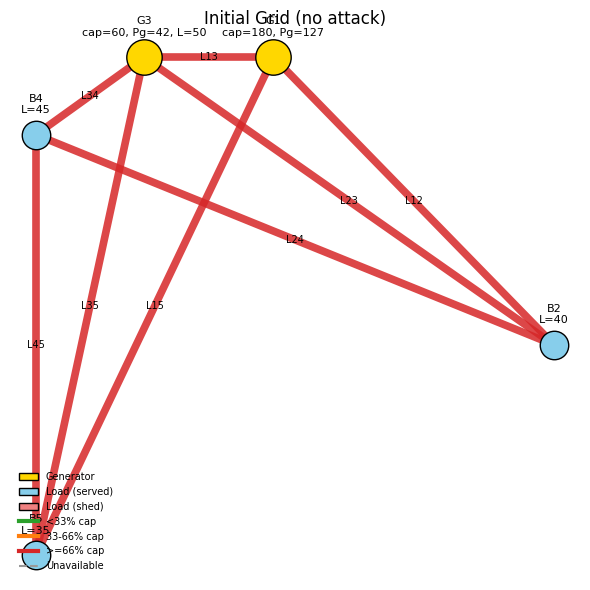

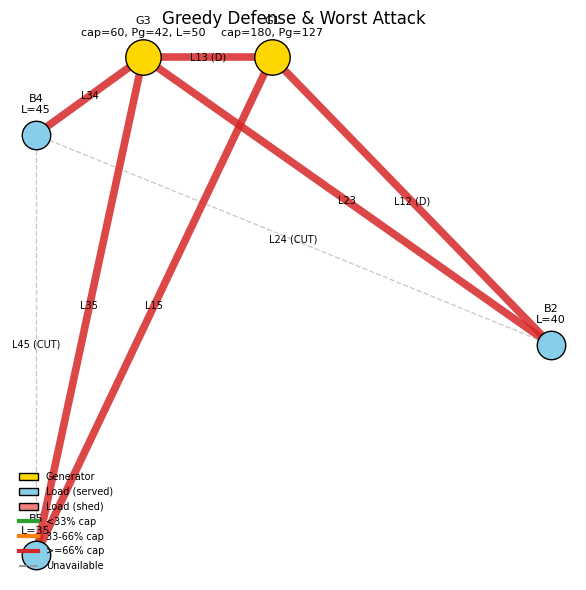

In [33]:
# Visualization utilities: plot grid topology and (approx) DC flow results (multi-generator aware)
from math import cos, sin, pi

try:
    import matplotlib.pyplot as plt
except ImportError:  # graceful degrade
    plt = None

import numpy as np

def compute_dc_flows(grid, defend=None, attack=None, shed=None, dispatch_rule='proportional'):
    """Approximate DC angles and flows for current availability (multi-generator).
    Susceptance b_ij approximated as 1/cap (toy).
    shed: dict bus->shed MW (if None, assume zero).
    dispatch_rule:
      'proportional' -> share generation in proportion to installed capacity
      'equal'        -> equal share among online generators up to capacity
    Returns (angles, flows, z, Pg_total, Pg_alloc) where Pg_alloc is dict of per-gen output.
    """
    m = grid.line_count()
    defend = defend or [0]*m
    attack = attack or [0]*m
    z = grid.availability_from_decisions(defend, attack)
    shed = shed or {}
    nbus = grid.n
    # Effective demand at load buses (generators assumed no native load here; if they had, they'd appear in loads dict)
    eff_load = {b: grid.loads.get(b,0.0) - shed.get(b,0.0) for b in grid.loads.keys()}
    total_demand = sum(v for v in eff_load.values() if v>0)
    total_cap = grid.total_generation_capacity()
    Pg_total = min(total_cap, total_demand)
    # Allocate generation
    gens = list(grid.generators.items())  # (bus, cap)
    Pg_alloc = {}
    if dispatch_rule == 'proportional':
        cap_sum = sum(cap for _,cap in gens) or 1.0
        for g_bus, cap in gens:
            Pg_alloc[g_bus] = Pg_total * (cap / cap_sum)
    else:  # equal share
        remaining = Pg_total
        k = len(gens)
        share = Pg_total / k if k else 0.0
        for g_bus, cap in gens:
            Pg_alloc[g_bus] = min(cap, share)
            remaining -= Pg_alloc[g_bus]
        # distribute leftover (if any) greedily
        if remaining > 1e-9:
            for g_bus, cap in gens:
                room = cap - Pg_alloc[g_bus]
                take = min(room, remaining)
                Pg_alloc[g_bus] += take
                remaining -= take
                if remaining <= 1e-9:
                    break
    # Injection vector p (positive generation, negative load) indexed by bus number
    p = np.zeros(nbus+1)
    for g_bus, Pg in Pg_alloc.items():
        p[g_bus] += Pg
    for b,d in eff_load.items():
        p[b] -= d
    # Build susceptance Laplacian L
    L = np.zeros((nbus+1, nbus+1))
    for i,e in enumerate(grid.edges):
        if z[i]==0: continue
        b = 1.0/max(1.0, e.capacity)
        u,v = e.u, e.v
        L[u,u] += b; L[v,v] += b
        L[u,v] -= b; L[v,u] -= b
    # Solve for angles with first generator bus as reference (smallest index among generators)
    if gens:
        ref_bus = min(g_bus for g_bus,_ in gens)
    else:
        ref_bus = 1
    buses = [b for b in range(1, nbus+1) if b != ref_bus]
    if buses:
        L_red = L[np.ix_(buses, buses)]
        p_red = p[buses]
        try:
            theta_red = np.linalg.solve(L_red + 1e-9*np.eye(len(buses)), p_red)
        except np.linalg.LinAlgError:
            theta_red = np.zeros(len(buses))
    else:
        theta_red = np.array([])
    theta = {ref_bus: 0.0}
    for k,b in enumerate(buses):
        theta[b] = float(theta_red[k])
    # Compute flows (scaled by capacity for visualization)
    flows = []
    for i,e in enumerate(grid.edges):
        if z[i]==0:
            flows.append(0.0); continue
        b = 1.0/max(1.0, e.capacity)
        f = b*(theta.get(e.u,0.0) - theta.get(e.v,0.0)) * e.capacity
        flows.append(f)
    return theta, flows, z, Pg_total, Pg_alloc

def _default_layout(grid):
    n = grid.n
    gens = sorted(grid.generators.keys())
    others = [b for b in range(1, n+1) if b not in gens]
    pos = {}
    radius = 1.0
    # place generators along a small arc on top
    g_count = len(gens) or 1
    for idx,g in enumerate(gens):
        ang = pi/2 + (idx - (g_count-1)/2)* (pi/10)
        pos[g] = (1.2*radius*cos(ang), 1.2*radius*sin(ang))
    for idx,b in enumerate(others):
        ang = 2*pi*idx/max(1,len(others))
        pos[b] = (radius*cos(ang), radius*sin(ang))
    return pos

def plot_grid(grid, defend=None, attack=None, shed=None, angles=None, flows=None, title=None,
              figsize=(6,6), annotate=True, show_legend=True, legend_loc='lower left'):
    """Plot grid topology and (optional) flows (multi-generator aware).
    defend, attack: lists length m.
    shed: dict bus->shed.
    angles, flows: optional precomputed.
    Node colors:
      gold=generator, skyblue=served load, lightcoral=load with shed>0.
    Edge colors by utilization; dashed gray if unavailable.
    """
    if plt is None:
        print("matplotlib not available; install it to enable plotting.")
        return
    m = grid.line_count()
    defend = defend or [0]*m
    attack = attack or [0]*m
    shed = shed or {}
    if angles is None or flows is None:
        angles, flows, z, Pg_total, Pg_alloc = compute_dc_flows(grid, defend, attack, shed)
    else:
        z = grid.availability_from_decisions(defend, attack)
        # recompute allocation summary for annotation
        _, _, _, Pg_total, Pg_alloc = compute_dc_flows(grid, defend, attack, shed)
    pos = _default_layout(grid)
    fig, ax = plt.subplots(figsize=figsize)
    # Nodes
    for b in range(1, grid.n+1):
        x,y = pos[b]
        is_gen = grid.is_generator(b)
        load = grid.loads.get(b,0.0)
        shed_b = shed.get(b,0.0)
        color = 'gold' if is_gen else ('lightcoral' if shed_b>1e-6 else 'skyblue')
        size = 650 if is_gen else 420
        ax.scatter(x, y, s=size, c=color, edgecolors='k', zorder=3)
        if annotate:
            label = f"G{b}" if is_gen else f"B{b}"
            extra = []
            if is_gen:
                extra.append(f"cap={int(grid.generators[b])}")
                gen_out = Pg_alloc.get(b)
                if gen_out is not None:
                    extra.append(f"Pg={int(gen_out)}")
            if load>0: extra.append(f"L={int(load)}")
            if shed_b>0: extra.append(f"shed={int(shed_b)}")
            ax.text(x, y+0.08, label+('\n'+', '.join(extra) if extra else ''),
                    ha='center', va='bottom', fontsize=8)
    # Edges
    for i,e in enumerate(grid.edges):
        u,v = e.u, e.v
        x1,y1 = pos[u]; x2,y2 = pos[v]
        avail = z[i]==1
        cut = (attack[i]==1 and defend[i]==0)
        defended = (defend[i]==1)
        f = flows[i] if flows is not None else 0.0
        util = min(1.0, abs(f)/max(1e-9, e.capacity)) if avail else 0.0
        def util_color(u_):
            if not avail: return '#999999'
            if u_ < 0.33: return '#2ca02c'
            if u_ < 0.66: return '#ff7f0e'
            return '#d62728'
        lw = 1.5 + 4*util
        ls = '-' if avail else '--'
        if not avail:
            lw = 1.0
        ax.plot([x1,x2],[y1,y2], linestyle=ls, linewidth=lw,
                color=util_color(util), alpha=0.85 if avail else 0.5, zorder=1)
        midx, midy = (x1+x2)/2, (y1+y2)/2
        if annotate:
            tag = e.name
            if defended: tag += ' (D)'
            if cut: tag += ' (CUT)'
            ax.text(midx, midy, tag, fontsize=7, ha='center', va='center')
    if show_legend:
        from matplotlib.lines import Line2D
        from matplotlib.patches import Patch
        node_handles = [
            Patch(facecolor='gold', edgecolor='k', label='Generator'),
            Patch(facecolor='skyblue', edgecolor='k', label='Load (served)'),
            Patch(facecolor='lightcoral', edgecolor='k', label='Load (shed)')
        ]
        edge_handles = [
            Line2D([0],[0], color='#2ca02c', lw=3, label='<33% cap'),
            Line2D([0],[0], color='#ff7f0e', lw=3, label='33-66% cap'),
            Line2D([0],[0], color='#d62728', lw=3, label='>=66% cap'),
            Line2D([0],[0], color='#999999', lw=1.5, ls='--', label='Unavailable')
        ]
        ax.legend(handles=node_handles+edge_handles, loc=legend_loc, fontsize=7, frameon=False)
    ax.set_title(title or f'Grid (Pg={int(Pg_total)})')
    ax.set_axis_off()
    plt.tight_layout()
    return fig, ax

# Demo usage (optional) - visualize before and after greedy defense worst attack with multiple generators
if __name__ == '__main__':
    grid, names = build_sample_grid()
    # add another generator for demo
    grid.add_generator(3, 60.0)
    Kd=2; Ka=2
    d_g, a_g, shed_g = greedy_defense(grid, Kd, Ka)
    plot_grid(grid, title='Initial Grid (no attack)')
    plot_grid(grid, d_g, a_g, title='Greedy Defense & Worst Attack')
    import matplotlib.pyplot as plt
    plt.show()

Random grid built: n_buses=10, lines=14, generators=[1, 4, 8], Kd=3, Ka=5
Generator capacities: {1: 69, 4: 63, 8: 197}
Lines: ['L1_3', 'L1_9', 'L1_10', 'L2_6', 'L2_8', 'L3_4', 'L3_5', 'L3_7', 'L3_8', 'L3_9', 'L4_7', 'L5_8', 'L6_9', 'L8_10']


C:\Users\debra\AppData\Local\Temp\ipykernel_15152\4233244151.py:330: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(v.T @ Q @ v)


[APT] iter 10/100: current best worst-case shed = 101.2266
[APT] iter 20/100: current best worst-case shed = 98.4071
[APT] iter 20/100: current best worst-case shed = 98.4071
[APT] iter 30/100: current best worst-case shed = 98.4071
[APT] iter 30/100: current best worst-case shed = 98.4071
[APT] iter 40/100: current best worst-case shed = 98.4071
[APT] iter 40/100: current best worst-case shed = 98.4071
[APT] iter 50/100: current best worst-case shed = 98.4071
[APT] iter 50/100: current best worst-case shed = 98.4071
[APT] iter 60/100: current best worst-case shed = 98.4071
[APT] iter 60/100: current best worst-case shed = 98.4071
[APT] iter 70/100: current best worst-case shed = 98.4071
[APT] iter 70/100: current best worst-case shed = 98.4071
[APT] iter 80/100: current best worst-case shed = 98.4071
[APT] iter 80/100: current best worst-case shed = 98.4071
[APT] iter 90/100: current best worst-case shed = 98.4071
[APT] iter 90/100: current best worst-case shed = 98.4071
[APT] iter 10

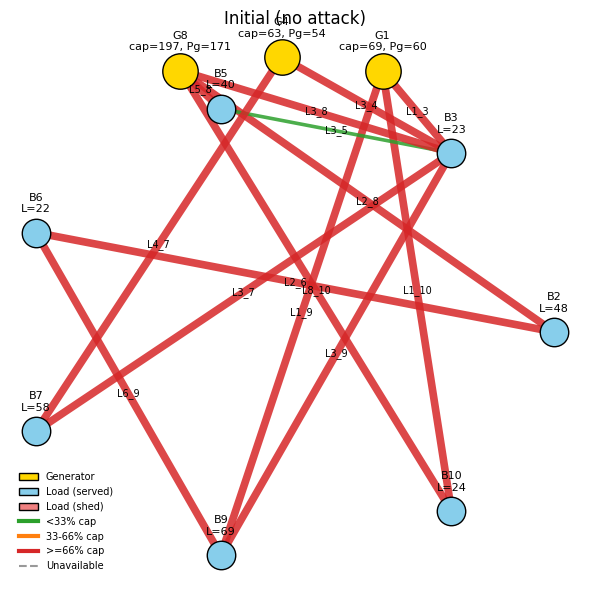

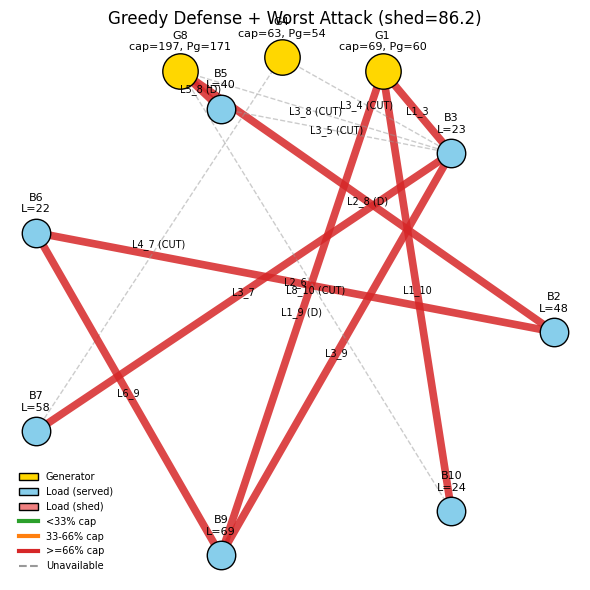

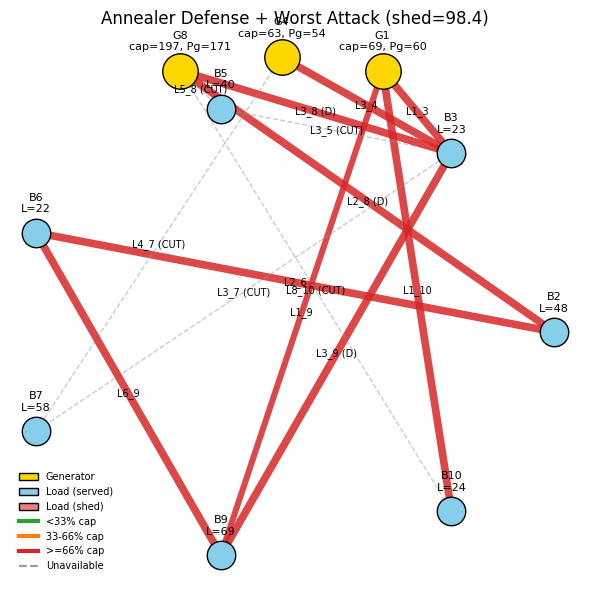

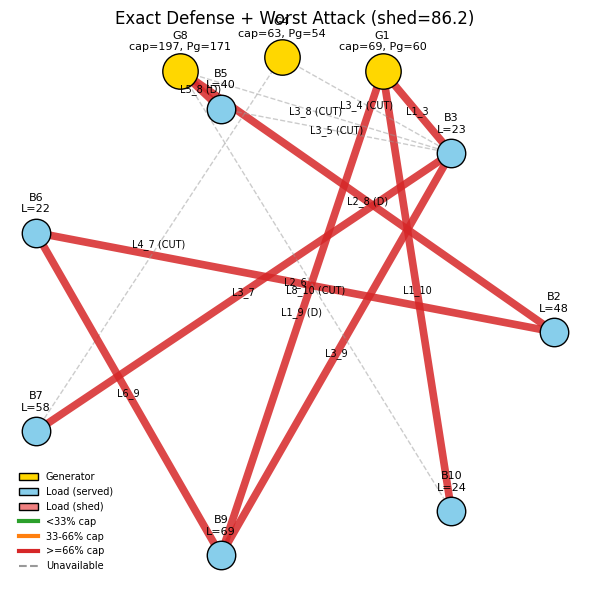

In [36]:
# Random grid experiment: compare greedy vs annealer vs exact (if feasible) with multi-generator support
import math as _math

def build_random_grid(n_buses=10, n_generators=1, avg_degree=2.5, load_min=20.0, load_max=70.0,
                      cap_min=40.0, cap_max=120.0, gen_margin=1.15, seed=1024):
    rng = random.Random(seed)
    # Choose generator buses (ensure at least bus 1)
    gen_buses = [1]
    candidates = [b for b in range(2, n_buses+1)]
    rng.shuffle(candidates)
    gen_buses += candidates[:max(0, n_generators-1)]
    gen_buses = sorted(gen_buses)
    # Assign loads to non-generator buses
    loads = {}
    for b in range(1, n_buses+1):
        if b not in gen_buses:
            loads[b] = rng.uniform(load_min, load_max)
    total_load = sum(loads.values())
    total_gen_cap = total_load * gen_margin
    # Split generation capacity proportional to random weights
    weights = [rng.random()+0.2 for _ in gen_buses]
    w_sum = sum(weights)
    caps = [total_gen_cap * w / w_sum for w in weights]
    # Initialize grid with first generator bus
    g = PowerGrid(n_buses=n_buses, gen_bus=gen_buses[0], generator_cap=caps[0])
    # Add additional generators
    for bus, cap in zip(gen_buses[1:], caps[1:]):
        g.add_generator(bus, cap)
    # Add loads
    for b,d in loads.items():
        g.add_load(b, d)
    # Connectivity: spanning tree + extra edges until target avg degree
    buses = list(range(1, n_buses+1))
    rng.shuffle(buses)
    added = set()
    for i in range(1, n_buses):
        u = buses[rng.randrange(0,i)]
        v = buses[i]
        if u>v: u,v=v,u
        added.add((u,v))
    possible = [(u,v) for u in range(1,n_buses+1) for v in range(u+1,n_buses+1) if (u,v) not in added]
    rng.shuffle(possible)
    target_m = int(avg_degree * n_buses / 2)
    for (u,v) in possible:
        if len(added) >= target_m: break
        added.add((u,v))
    for (u,v) in sorted(added):
        cap = rng.uniform(cap_min, cap_max)
        g.add_line(u,v,cap,f"L{u}_{v}")
    return g, gen_buses

def brute_force_defense(grid, Kd, Ka, max_states=3000):
    m = grid.line_count()
    from math import comb
    total = comb(m,Kd)
    if total > max_states:
        return None  # skip
    best = (None, None, float('inf'))
    for D in itertools.combinations(range(m), Kd):
        d = [0]*m
        for i in D: d[i]=1
        a_star, worst = enumerate_best_attack(grid, d, Ka)
        if worst < best[2]:
            best = (d, a_star, worst)
    return best  # (d, a, shed)

def run_random_experiment(seed=2, n_buses=10, n_generators=2, avg_degree=2.5, Kd=None, Ka=None,
                          anneal_iters=500, R=12, Tmax=4.0, Tmin=0.02, plot=True,
                          dispatch_rule='proportional'):
    random.seed(seed)
    grid, gen_buses = build_random_grid(n_buses=n_buses, n_generators=n_generators, avg_degree=avg_degree, seed=seed)
    m = grid.line_count()
    if Kd is None: Kd = max(1, m//6)
    if Ka is None: Ka = max(1, m//6)
    print(f"Random grid built: n_buses={n_buses}, lines={m}, generators={gen_buses}, Kd={Kd}, Ka={Ka}")
    print('Generator capacities:', {b:int(c) for b,c in grid.generators.items()})
    names = [e.name for e in grid.edges]
    print('Lines:', names)
    # Baseline greedy
    d_g, a_g, shed_g = greedy_defense(grid, Kd, Ka)
    # Surrogate & QUBO for annealer
    a0, a1, a2, rmse = fit_quadratic_surrogate(grid, Ka=Ka, max_enum=min(Ka,2))
    Q = build_qubo(a0, a1, a2, m, Kd, Ka, mu_d=400.0, mu_a=400.0)
    d_a, a_a, shed_a = apt_annealer(grid, Q, Kd, Ka, iters=anneal_iters, R=R, Tmax=Tmax, Tmin=Tmin, seed=seed+10)
    # Exact if small
    exact = brute_force_defense(grid, Kd, Ka)
    if exact is not None:
        d_e, a_e, shed_e = exact
    else:
        d_e = a_e = None; shed_e = None
    print('\n=== Results (true worst-case shed) ===')
    print(f"Greedy : {shed_g:.2f}")
    print(f"Anneal : {shed_a:.2f}")
    if shed_e is not None:
        print(f"Exact  : {shed_e:.2f}")
    else:
        print("Exact  : (skipped - too many defenses)")
    # Plot flows
    if plot:
        plot_grid(grid, title='Initial (no attack)')
        plot_grid(grid, d_g, a_g, title=f'Greedy Defense + Worst Attack (shed={shed_g:.1f})')
        plot_grid(grid, d_a, a_a, title=f'Annealer Defense + Worst Attack (shed={shed_a:.1f})')
        if shed_e is not None:
            plot_grid(grid, d_e, a_e, title=f'Exact Defense + Worst Attack (shed={shed_e:.1f})')
    return {
        'grid': grid,
        'greedy': {'d': d_g, 'a': a_g, 'shed': shed_g},
        'anneal': {'d': d_a, 'a': a_a, 'shed': shed_a},
        'exact': {'d': d_e, 'a': a_e, 'shed': shed_e},
        'surrogate_rmse': rmse
    }

# Execute demo automatically if run as script
if __name__ == '__main__':
    res = run_random_experiment(seed=2025, n_buses=10, n_generators=3, avg_degree=2.8, Kd=3, Ka=5, anneal_iters=100, R=10, Tmax=4.0, Tmin=0.02, plot=True)
    import matplotlib.pyplot as plt
    plt.show()